# Initialization

In [73]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.sql.functions import mean, col, desc, count, isnull, isnan, when, rank, sum
import pandas as pd
import matplotlib.pyplot as plt


spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.ui.showConsoleProgress", "false") \
    .getOrCreate()
    # .config("spark.master", "spark://127.0.0.1:7077") \


spark.sparkContext.setLogLevel(logLevel='ERROR')


# Load model

In [74]:
from pyspark.ml.clustering import KMeansModel
model = KMeansModel.load("uber_kmeans_model")


# Consumer

In [75]:
from kafka import KafkaConsumer
from pyspark.sql.types import StructType, StructField, TimestampType, IntegerType
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.functions import to_timestamp

schema = StructType([
    StructField("Date/Time", StringType(), True),
    StructField("Lat", DoubleType(), True),
    StructField("Lon", DoubleType(), True),
    StructField("Base", StringType(), True)
])

consumer = KafkaConsumer('uber_a', bootstrap_servers=['127.0.0.1:9092']) #, max_poll_records=100, group_id='uber_group')


## Poll processing

In [81]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['Lat', 'Lon'], outputCol="vector_features")

rows = []
while True:
    partition = ""
    for _, partition in consumer.poll(timeout_ms=30000, max_records=999999).items():
        for msg in partition:
            data = msg.value.decode('utf-8').split(',')
            rows.append({"Date/Time": data[0], "Lat": float(data[1]), "Lon": float(data[2]), "Base": data[3]})
            print(f'\r{len(rows)}', end='')
    if len(partition) == 0:
        break

# to df
df1 = spark.createDataFrame(rows, schema=schema)

# vector assembler
df2 = assembler.transform(df1)

# predict cluster
df_final = model.transform(df2)


162613

# Resulting df

In [92]:
df_final.show()


+----------------+-------+--------+------+------------------+----------+
|       Date/Time|    Lat|     Lon|  Base|   vector_features|prediction|
+----------------+-------+--------+------+------------------+----------+
|8/1/2014 0:00:00|40.6754| -74.017|B02682| [40.6754,-74.017]|         2|
|8/1/2014 0:01:00|40.7073|-74.0054|B02598|[40.7073,-74.0054]|         2|
|8/1/2014 0:01:00|40.7633|-73.9891|B02617|[40.7633,-73.9891]|         1|
|8/1/2014 0:08:00|40.7577|-73.9715|B02617|[40.7577,-73.9715]|         1|
|8/1/2014 0:09:00| 40.726|-73.9918|B02512| [40.726,-73.9918]|         2|
|8/1/2014 0:12:00|40.7209|-74.0507|B02512|[40.7209,-74.0507]|         2|
|8/1/2014 0:15:00|40.7223|-73.9887|B02598|[40.7223,-73.9887]|         2|
|8/1/2014 0:16:00|40.6762|-73.9708|B02682|[40.6762,-73.9708]|         2|
|8/1/2014 0:19:00| 40.722|-73.9961|B02682| [40.722,-73.9961]|         2|
|8/1/2014 0:20:00|40.7643|-73.9983|B02598|[40.7643,-73.9983]|         1|
|8/1/2014 0:23:00|40.6858|-73.9805|B02598|[40.6858,

# Visualization

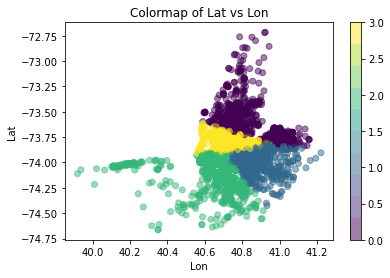

In [89]:
pdf = df_final.select(col("Lat"), col("Lon"), col("prediction")).toPandas()
cmap = plt.cm.get_cmap("viridis", 10)

plt.scatter(x=pdf['Lat'], y=pdf['Lon'], c=pdf['prediction'], cmap=cmap, alpha=0.5)
plt.colorbar()
plt.title("Colormap of Lat vs Lon")
plt.xlabel("Lon")
plt.ylabel("Lat")
plt.show()


# To Cassandra

In [ ]:
import uuid
from cassandra.cqlengine import columns, connection
from cassandra.cqlengine.management import sync_table
from cassandra.cqlengine.models import Model
from cassandra.cqlengine.query import BatchQuery


In [ ]:
# 1
class Aug2014(Model):
    id          = columns.TimeUUID(primary_key=True, default=uuid.uuid1)
    date_time   = columns.DateTime()
    lat         = columns.Double()
    lon         = columns.Double()
    base        = columns.Text()
    prediction  = columns.SmallInt()

connection.setup(['127.0.0.1'], "uber", protocol_version=3)
sync_table(Aug2014)


In [155]:
# 2
class Aug2014(Model):
    id          = columns.TimeUUID(primary_key=True, default=uuid.uuid1)
    date_time   = columns.DateTime()
    lat         = columns.Double()
    lon         = columns.Double()
    base        = columns.Text()
    prediction  = columns.SmallInt(index=True)

connection.setup(['127.0.0.1'], "uber", protocol_version=3)
sync_table(Aug2014)


In [131]:
# 3
class Aug2014(Model):
    prediction  = columns.SmallInt(primary_key=True)
    id          = columns.TimeUUID(primary_key=True, default=uuid.uuid1)
    date_time   = columns.DateTime()
    lat         = columns.Double()
    lon         = columns.Double()
    base        = columns.Text()

connection.setup(['127.0.0.1'], "uber", protocol_version=3)
sync_table(Aug2014)


In [170]:
# 4
class Aug2014(Model):
    id          = columns.TimeUUID(primary_key=True, default=uuid.uuid1)
    date_time   = columns.DateTime()
    lat         = columns.Double()
    lon         = columns.Double()
    base        = columns.Text()
    prediction  = columns.SmallInt(primary_key=True, partition_key=True)

connection.setup(['127.0.0.1'], "uber", protocol_version=3)
sync_table(Aug2014)


In [168]:
# 5
class Aug2014(Model):
    id          = columns.TimeUUID(primary_key=True, default=uuid.uuid1)
    date_time   = columns.DateTime(index=True)
    lat         = columns.Double()
    lon         = columns.Double()
    base        = columns.Text()
    prediction  = columns.SmallInt(primary_key=True, partition_key=True)

connection.setup(['127.0.0.1'], "uber", protocol_version=3)
sync_table(Aug2014)


In [180]:
from datetime import datetime
date_format = "%m/%d/%Y %H:%M:%S"

df_list = df_final.collect()
batch_max_size = 65535
df_batches = [df_list[i:i+batch_max_size] for i in range(0, len(df_list), batch_max_size)]

for df_batch in df_batches:
    for row in df_batch:
        batch = BatchQuery()
        Aug2014.batch(batch).create(
            date_time = datetime.strptime(row['Date/Time'], date_format),
            lat = row['Lat'],
            lon = row['Lon'],
            base = row['Base'],
            prediction = row['prediction'],
        )
        batch.execute()


# [Tests]

In [179]:
# 6
class Test(Model):
    id          = columns.TimeUUID(primary_key=True, default=uuid.uuid1)
    date_time   = columns.DateTime(primary_key=True, clustering_order="ASC")
    lat         = columns.Double()
    lon         = columns.Double()
    base        = columns.Text()
    prediction  = columns.SmallInt(primary_key=True, partition_key=True)

connection.setup(['127.0.0.1'], "uber", protocol_version=3)
sync_table(Aug2014)


In [198]:
# 7
class Test(Model):
    id          = columns.TimeUUID(primary_key=True, default=uuid.uuid1)
    date_time   = columns.DateTime(primary_key=True, clustering_order="ASC")
    lat         = columns.Double(primary_key=True, partition_key=True)
    lon         = columns.Double(primary_key=True, partition_key=True)
    base        = columns.Text()
    prediction  = columns.SmallInt(primary_key=True)

connection.setup(['127.0.0.1'], "uber", protocol_version=3)
sync_table(Test)


In [199]:
import math
from datetime import datetime
date_format = "%m/%d/%Y %H:%M:%S"

df_list = df_final.collect()
batch_max_size = 65535
df_batches = [df_list[i:i+batch_max_size] for i in range(0, len(df_list), batch_max_size)]

for df_batch in df_batches:
    for row in df_batch:
        batch = BatchQuery()
        Test.batch(batch).create(
            date_time = datetime.strptime(row['Date/Time'], date_format),
            lat = math.floor(row['Lat'] * 10) / 10,
            lon = math.floor(row['Lon'] * 10) / 10,
            base = row['Base'],
            prediction = row['prediction'],
        )
        batch.execute()
